In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform=transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
path='Data/CATS_DOGS'
train_data=datasets.ImageFolder(root=os.path.join(path,'train'),
                                transform=train_transform)
test_data=datasets.ImageFolder(root=os.path.join(path,'test'),
                               transform=test_transform)
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=True)
max_train=800
max_test=800

class_names=train_data.classes
class_names

['CAT', 'DOG']

[1 0 1 1 1]
[0 1 1 1 1]


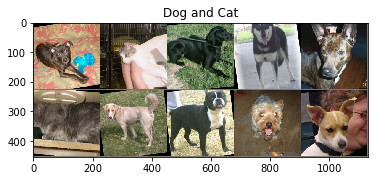

In [7]:
for images,labels in train_loader:
    break
im=make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
print(labels.numpy()[:5])
print(labels.numpy()[5:])
plt.title('Dog and Cat')
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [8]:
alex=models.alexnet(pretrained=True).cuda()
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [6]:
for param in alex.parameters():
    param.requires_grad=False

In [9]:
alex.classifier=nn.Sequential(nn.Dropout(),
                              nn.Linear(9216,2048),
                              nn.ReLU(),
                              nn.Dropout(),
                              nn.Linear(2048,512),
                              nn.ReLU(),
                              nn.Linear(512,2)).cuda()
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
 

In [10]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.parameters(),lr=0.001)

In [ ]:
import time
start=time.time()
train_losses=[]
test_losses=[]
train_counts=[]
test_counts=[]

max_trn_batch = 800
max_tst_batch = 300

epochs=3
for i in range(epochs):
    i=i+1
    train_count=0
    test_count=0
    for b,(x_train,y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b=b+1
        x_train, y_train = x_train.cuda(), y_train.cuda()
        y_pred=alex(x_train)
        loss=criterion(y_pred,y_train)

        train_count+=(y_pred.argmax(dim=1)==y_train).sum
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%200 == 0:
            print(f'epoch {i} batch {b} loss {loss}')
    train_losses.append(loss)
    train_counts.append(train_count)
    with torch.no_grad():
        for b,(x_test,y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            b=b+1
            x_test, y_test = x_test.cuda(), y_test.cuda()
            y_pred=alex(x_test)
            test_count+=(y_pred.argmax(dim=1)==y_test).sum

    test_losses.append(criterion(y_pred,y_test))
    test_counts.append(test_count)

end=time.time()
print(f'It takes {end-start} seconds')

In [4]:
for images,labels in train_loader:
    break
images

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -0.3712, -0.3369, -0.8678],
          [-2.1179, -2.1179, -2.1179,  ...,  1.3070,  1.3242,  0.6049],
          ...,
          [ 0.3309,  1.1700,  1.0502,  ..., -2.1179, -2.1179, -2.1179],
          [-0.9020, -0.4397, -0.5082,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -0.3200, -0.2850, -0.8102],
          [-2.0357, -2.0357, -2.0357,  ...,  1.3431,  1.3606,  0.6604],
          ...,
          [ 0.5903,  1.4307,  1.3081,  ..., -2.0357, -2.0357, -2.0357],
          [-0.7227, -0.2675, -0.3375,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [5]:
type(images)

torch.Tensor

In [7]:
a=images[0]
a.shape[0]

3

In [ ]:
b = torch.FloatTensor([1., 2.]).cuda()